In [1]:
# ==========================
# Основные библиотеки
# ==========================
import numpy as np
import pandas as pd
import warnings

# ==========================
# Визуализация
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ==========================
# Предобработка данных
# ==========================
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler

# ==========================
# Модели и обучение
# ==========================
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,
    StackingRegressor, AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# ==========================
# Метрики
# ==========================
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
)

# ==========================
# Библиотеки для бустинга
# ==========================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

# ==========================
# Статистика
# ==========================
from scipy.stats import f_oneway


In [2]:
df = pd.read_csv("df.csv")
df_bin = pd.read_csv("df_bin.csv")
df_cut = pd.read_csv("df_cut.csv")
df_cut_bin = pd.read_csv("df_cut_bin.csv")

Сравниваем разные модели

In [4]:
!pip install catboost

In [5]:
df = df.drop(columns=['CC50, mM'])
df_bin = df_bin.drop(columns=['CC50, mM'])
df_cut = df_cut.drop(columns=['CC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['CC50, mM'])
df = df.drop(columns=['SI'])
df_bin = df_bin.drop(columns=['SI'])
df_cut = df_cut.drop(columns=['SI'])
df_cut_bin = df_cut_bin.drop(columns=['SI'])
df = df.drop(columns=['log_SI'])
df_bin = df_bin.drop(columns=['log_SI'])
df_cut = df_cut.drop(columns=['log_SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_SI'])
df = df.drop(columns=['IC50, mM'])
df_bin = df_bin.drop(columns=['IC50, mM'])
df_cut = df_cut.drop(columns=['IC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['IC50, mM'])
df = df.drop(columns=['log_IC50'])
df_bin = df_bin.drop(columns=['log_IC50'])
df_cut = df_cut.drop(columns=['log_IC50'])
df_cut_bin = df_cut_bin.drop(columns=['log_IC50'])

=== Evaluation on df ===


Cross-validation (234 features): 100%|██████████| 9/9 [07:51<00:00, 52.37s/it] 


=== Evaluation on df_cut ===


Cross-validation (158 features): 100%|██████████| 9/9 [04:39<00:00, 31.03s/it]


=== Evaluation on df_bin ===


Cross-validation (234 features): 100%|██████████| 9/9 [07:28<00:00, 49.78s/it] 


=== Evaluation on df_cut_bin ===


Cross-validation (94 features): 100%|██████████| 9/9 [03:53<00:00, 25.95s/it]


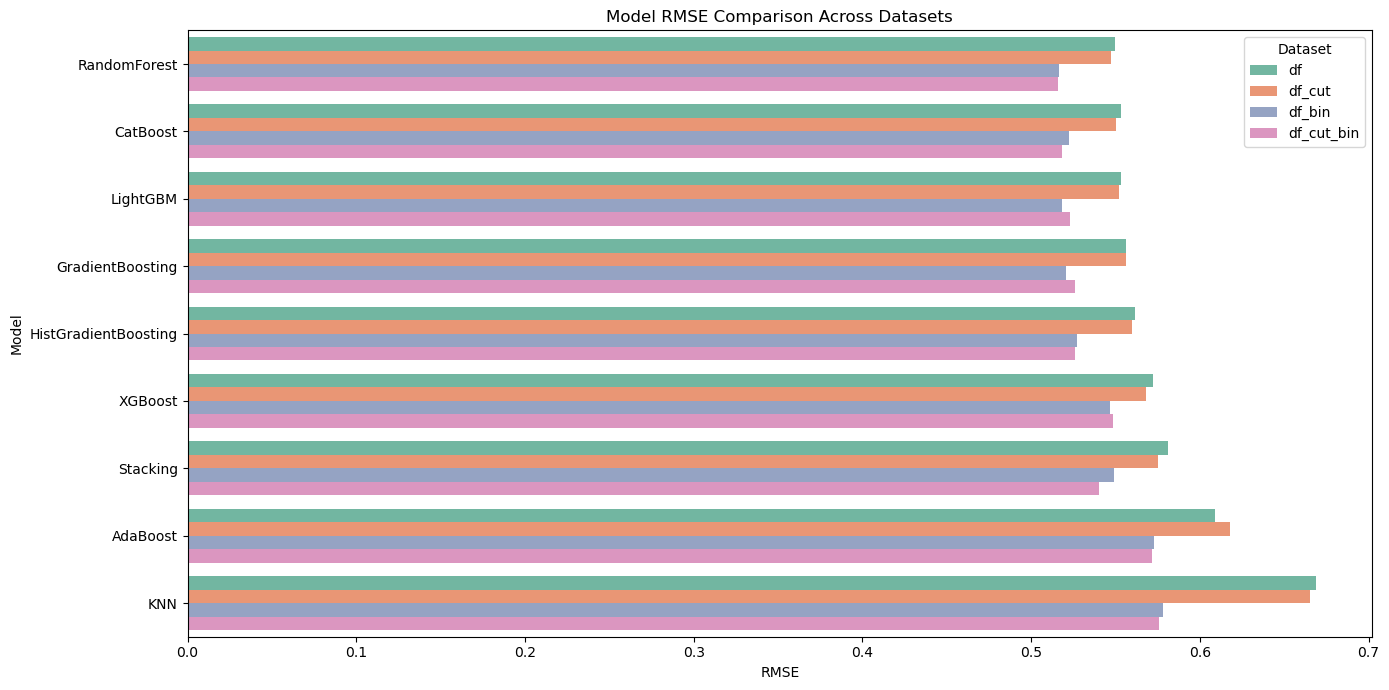

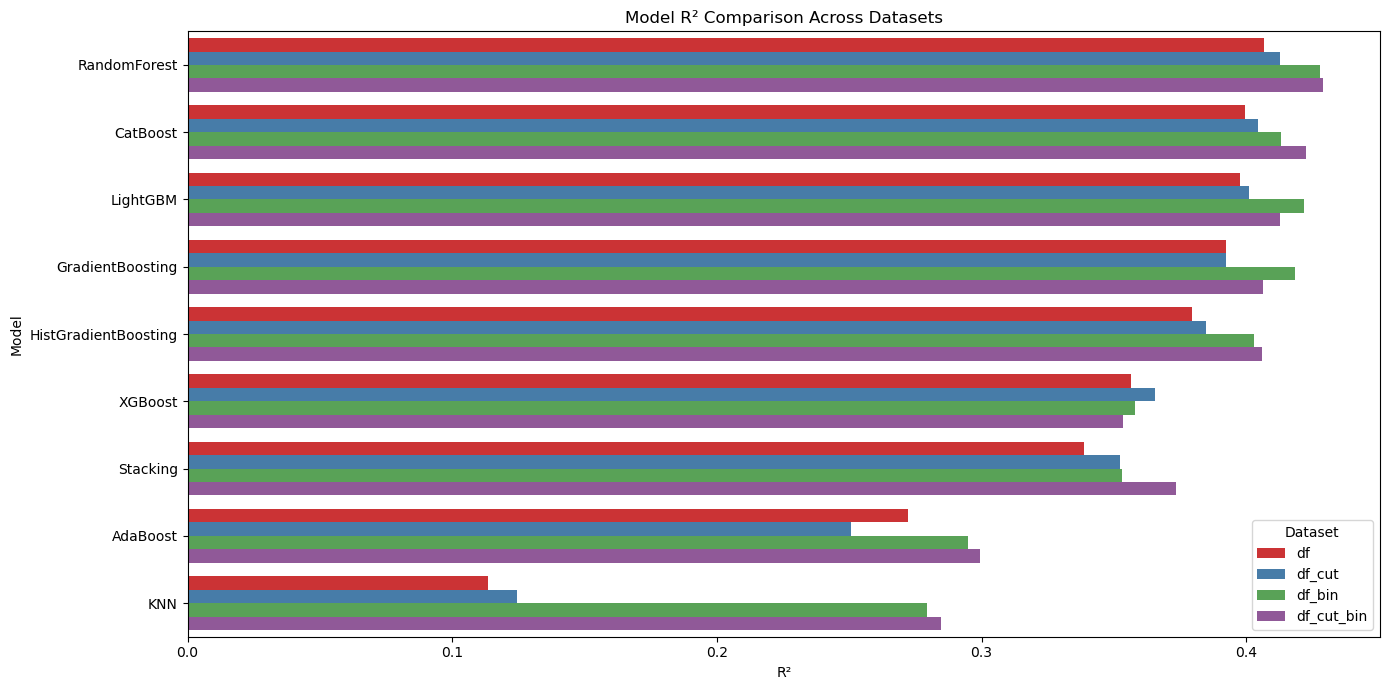


Model metrics comparison:
                         MAE                               RMSE          \
Dataset                   df  df_bin  df_cut df_cut_bin      df  df_bin   
Model                                                                     
AdaBoost              0.4840  0.4695  0.4894     0.4676  0.6086  0.5729   
CatBoost              0.3899  0.3773  0.3875     0.3748  0.5531  0.5225   
GradientBoosting      0.3918  0.3798  0.3925     0.3847  0.5563  0.5204   
HistGradientBoosting  0.3851  0.3714  0.3823     0.3710  0.5618  0.5269   
KNN                   0.4559  0.3981  0.4533     0.3963  0.6687  0.5782   
LightGBM              0.3758  0.3625  0.3761     0.3647  0.5535  0.5185   
RandomForest          0.3841  0.3721  0.3843     0.3726  0.5496  0.5163   
Stacking              0.4429  0.4294  0.4362     0.4217  0.5811  0.5492   
XGBoost               0.3864  0.3766  0.3844     0.3799  0.5722  0.5466   

                                             R²                         

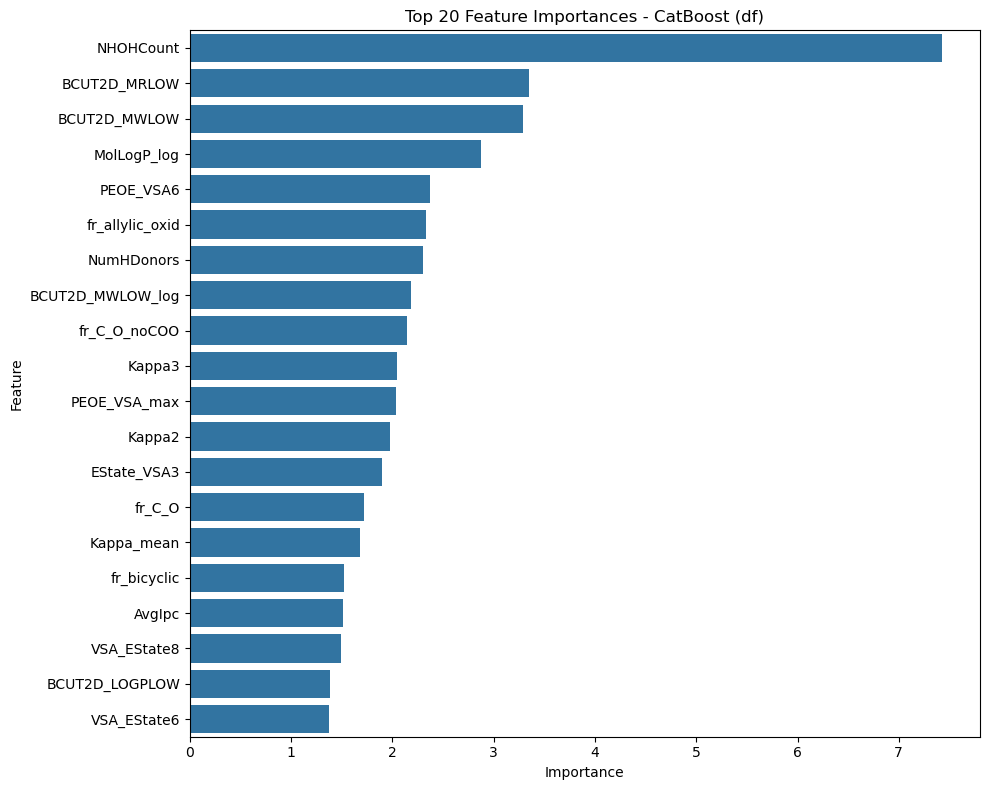

Best model on df by RMSE: RandomForest


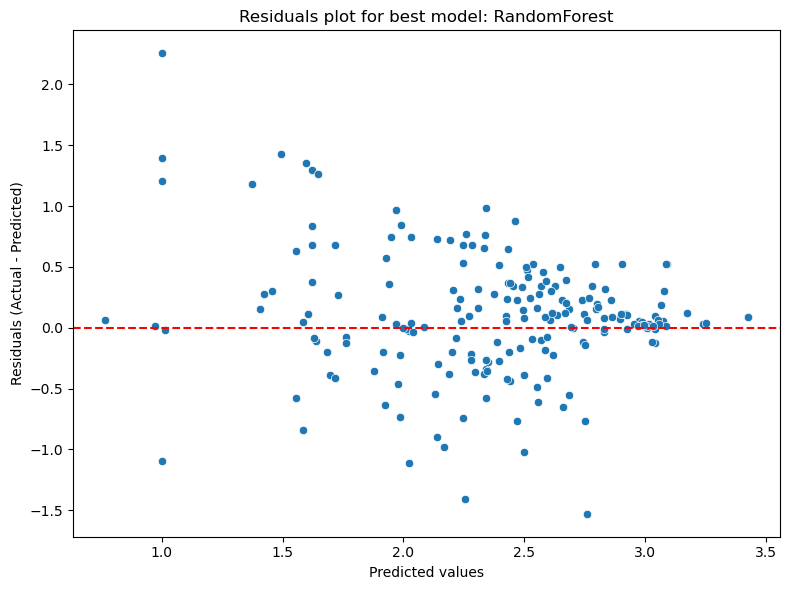

In [12]:
warnings.filterwarnings("ignore")

# Очистка имён колонок и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, verbosity=0)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42)),
]

final_estimator = LinearRegression()
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

models = {
    "KNN": KNeighborsRegressor(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(
        random_state=42,
        colsample_bytree=0.65,
        learning_rate=0.102,
        max_depth=6,
        min_child_samples=16,
        n_estimators=451,
        num_leaves=25,
        reg_alpha=0.98,
        reg_lambda=0.44,
        subsample=0.65,
        verbose=-1
    ),
    "CatBoost": CatBoostRegressor(
        verbose=0,
        random_state=42,
        bagging_temperature=0.13,
        depth=4,
        iterations=626,
        l2_leaf_reg=4.2,
        learning_rate=0.04
    ),
    "Stacking": stacking_model
}


def evaluate_models(df_input, y_col='log_CC50'):
    df_eval = df_input.copy()
    df_eval = df_eval.drop(columns=['Unnamed_0'], errors='ignore')

    X = df_eval.drop(columns=[y_col])
    y = df_eval[y_col]

    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        try:
            cv_results = cross_validate(
                model, X_scaled, y,
                cv=kf,
                scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_median_absolute_error'],
                return_train_score=False,
                n_jobs=-1
            )

            mae_mean = -np.mean(cv_results['test_neg_mean_absolute_error'])
            mse_mean = -np.mean(cv_results['test_neg_mean_squared_error'])
            rmse_mean = np.sqrt(mse_mean)
            r2_mean = np.mean(cv_results['test_r2'])
            medae_mean = -np.mean(cv_results['test_neg_median_absolute_error'])

            results.append({
                "Model": name,
                "MAE": mae_mean,
                "MSE": mse_mean,
                "RMSE": rmse_mean,
                "MedAE": medae_mean,
                "R²": r2_mean
            })
        except Exception as e:
            print(f"Error in model {name}: {e}")
    return pd.DataFrame(results).sort_values(by="RMSE"), X_scaled, y, imputer, scaler

# Оценка всех датасетов и сбор результатов
print("=== Evaluation on df ===")
results_df, X_df_scaled, y_df, imputer_df, scaler_df = evaluate_models(df)
results_df['Dataset'] = 'df'

print("=== Evaluation on df_cut ===")
results_df_cut, X_cut_scaled, y_cut, imputer_cut, scaler_cut = evaluate_models(df_cut)
results_df_cut['Dataset'] = 'df_cut'

print("=== Evaluation on df_bin ===")
results_df_bin, X_bin_scaled, y_bin, imputer_bin, scaler_bin = evaluate_models(df_bin)
results_df_bin['Dataset'] = 'df_bin'

print("=== Evaluation on df_cut_bin ===")
results_df_cut_bin, X_cut_bin_scaled, y_cut_bin, imputer_cut_bin, scaler_cut_bin = evaluate_models(df_cut_bin)
results_df_cut_bin['Dataset'] = 'df_cut_bin'

comparison_df = pd.concat([results_df, results_df_cut, results_df_bin, results_df_cut_bin], ignore_index=True)

# Визуализация RMSE
plt.figure(figsize=(14, 7))
sns.barplot(data=comparison_df, x='RMSE', y='Model', hue='Dataset', palette='Set2')
plt.title("Model RMSE Comparison Across Datasets")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# Визуализация R²
plt.figure(figsize=(14, 7))
sns.barplot(data=comparison_df, x='R²', y='Model', hue='Dataset', palette='Set1')
plt.title("Model R² Comparison Across Datasets")
plt.xlabel("R²")
plt.ylabel("Model")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

print("\nModel metrics comparison:")
print(comparison_df.pivot_table(index="Model", columns="Dataset", values=["RMSE", "R²", "MAE"]).round(4))

# --- Визуализация важности признаков для CatBoost на df (пример) ---
cat_model = models['CatBoost']
cat_model.fit(X_df_scaled, y_df)

# Получение важности признаков
feature_importances = cat_model.get_feature_importance(Pool(X_df_scaled, label=y_df))
feat_imp_df = pd.DataFrame({
    'Feature': X_df_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title("Top 20 Feature Importances - CatBoost (df)")
plt.tight_layout()
plt.show()

# --- График остатков для лучшей модели на df ---
# Определим лучшую модель по RMSE на df
best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
print(f"Best model on df by RMSE: {best_model_name}")

best_model = models[best_model_name]

# Для графика остатков нужна обучающая и тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_df_scaled, y_df, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residuals plot for best model: {best_model_name}')
plt.tight_layout()
plt.show()

# --- Сохраняем результаты в Excel и PDF ---
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('regression_evaluation_report_CC50.pdf') as pdf:
    # RMSE Plot
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_df, x='RMSE', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model RMSE Comparison Across Datasets")
    plt.xlabel("RMSE")
    plt.ylabel("Model")
    plt.legend(title="Dataset")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # R² Plot
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_df, x='R²', y='Model', hue='Dataset', palette='Set1')
    plt.title("Model R² Comparison Across Datasets")
    plt.xlabel("R²")
    plt.ylabel("Model")
    plt.legend(title="Dataset")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Feature importance CatBoost
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
    plt.title("Top 20 Feature Importances - CatBoost (df)")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Residuals plot best model
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residuals plot for best model: {best_model_name}')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Табличное сравнение
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.axis('off')
    ax.axis('tight')

    table_data = comparison_df.pivot_table(
        index="Model",
        columns="Dataset",
        values=["RMSE", "R²", "MAE"]
    ).round(4)

    tbl = ax.table(
        cellText=table_data.values,
        colLabels=[f'{metric}_{ds}' for metric, ds in table_data.columns],
        rowLabels=table_data.index,
        loc='center',
        cellLoc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    ax.set_title("Model metrics comparison")
    pdf.savefig()
    plt.close()

with pd.ExcelWriter("regression_comparison_metrics_CC50.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_df_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_df_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_df_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_df.to_excel(writer, sheet_name="Comparison", index=False)


двухэтапная настройка LightGBM на данных df__bin: сначала RandomizedSearchCV для определения перспективной области параметров, затем GridSearchCV для её уточнения

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform
from lightgbm import LGBMRegressor
from tqdm import tqdm

# --- 1. Данные и подготовка ---

X = df_bin.drop(columns=['log_CC50'])
y = df_bin['log_CC50']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# --- 2. Базовая модель ---
base_model = LGBMRegressor(random_state=42)

# --- 3. Метрики ---
scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# --- 4. RandomizedSearchCV ---
param_dist = {
    'num_leaves': randint(20, 100),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(300, 800),
    'min_child_samples': randint(10, 100),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0)
}

print(" Запуск RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring=scoring,
    refit='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

with tqdm(total=1, desc="RandomizedSearchCV") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)

print(" Предварительно лучшие параметры (RandomizedSearchCV):")
print(random_search.best_params_)

# --- 5. GridSearchCV — тонкая настройка ---
best_params = random_search.best_params_
param_grid = {
    'num_leaves': sorted(list(set([
        best_params['num_leaves'] - 10, best_params['num_leaves'], best_params['num_leaves'] + 10
    ]))),
    'max_depth': sorted(list(set([
        best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1
    ]))),
    'learning_rate': [round(best_params['learning_rate'] * r, 3) for r in [0.8, 1.0, 1.2]],
    'n_estimators': [best_params['n_estimators'] - 100, best_params['n_estimators'], best_params['n_estimators'] + 100],
    'min_child_samples': sorted(list(set([
        best_params['min_child_samples'] - 10, best_params['min_child_samples'], best_params['min_child_samples'] + 10
    ]))),
    'subsample': [round(best_params['subsample'] * r, 2) for r in [0.8, 1.0]],
    'colsample_bytree': [round(best_params['colsample_bytree'] * r, 2) for r in [0.8, 1.0]],
    'reg_alpha': [round(best_params['reg_alpha'] * r, 2) for r in [0.8, 1.0, 1.2]],
    'reg_lambda': [round(best_params['reg_lambda'] * r, 2) for r in [0.8, 1.0, 1.2]]
}

# Удаление некорректных (отрицательных) значений
for key, vals in param_grid.items():
    param_grid[key] = sorted(list(set([v for v in vals if v >= 0])))

print("\n Запуск GridSearchCV...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='r2',
    cv=3,
    n_jobs=-1,
    return_train_score=True
)

with tqdm(total=1, desc="GridSearchCV") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

print(" Точно настроенные параметры (GridSearchCV):")
print(grid_search.best_params_)

# --- 6. Оценка на тесте ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\n Метрики на тестовой выборке:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²:   {r2_test:.4f}")

# --- 7. Сохранение результатов ---
results = {
    "best_params_random": random_search.best_params_,
    "best_params_grid": grid_search.best_params_,
    "rmse_test": rmse_test,
    "r2_test": r2_test
}

with open("results_lgbm.json", "w") as f:
    json.dump(results, f, indent=4)

print("\n Результаты сохранены в results_lgbm.json")

# --- 8. График Actual vs Predicted ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('True log(CC50)')
plt.ylabel('Predicted log(CC50)')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_regression_actual_vs_predicted_lgbm.png")
plt.show()

# --- 9. Feature Importance ---
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 30))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (LightGBM)")
plt.tight_layout()
plt.savefig("CC50_regression_feature_importance_lgbm.png")
plt.show()


 Запуск RandomizedSearchCV...


RandomizedSearchCV:   0%|          | 0/1 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import joblib

# Копируем и очищаем данные
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация средним значением
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Параметры модели CatBoost
catboost_params = {
    'verbose': 0,
    'random_state': 42,
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04
}

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

catboost_model_eval = CatBoostRegressor(**catboost_params)
catboost_model_eval.fit(X_train, y_train)

y_pred = catboost_model_eval.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50): Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.close()

# Важность признаков
catboost_model_final = CatBoostRegressor(**catboost_params)
catboost_model_final.fit(X_imputed, y)

feature_importances = catboost_model_final.get_feature_importance()
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log(CC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.close()

# Сохранение финальной модели
joblib.dump(catboost_model_final, 'regression_CC50_catboost_final_model_df_to_SI_class.pkl')
print(" Модель CatBoost успешно сохранена.")


Running 5-fold cross-validation...
Fold 1 R²: 0.4028
Fold 2 R²: 0.4361
Fold 3 R²: 0.3383
Fold 4 R²: 0.4615
Fold 5 R²: 0.3798

Cross-validation results:
MAE: 0.3881 ± 0.0143
RMSE: 0.5508 ± 0.0233
R²: 0.4037 ± 0.0430

Test set performance:
MAE: 0.3725
MSE: 0.2705
RMSE: 0.5201
MedAE: 0.2284
R²: 0.3955
✅ Модель CatBoost успешно сохранена.


In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib

# Копируем и очищаем данные
df_copy = df_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация средним значением
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Параметры модели LightGBM
lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)

y_pred = lgb_model_eval.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50): Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_residuals_plot.png")
plt.close()

# Важность признаков
lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log(CC50): Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_feature_importance_top30.png")
plt.close()

# Сохранение финальной модели
joblib.dump(lgb_model_final, 'regression_CC50_lightgbm_final_model_bin.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_bin.pkl'")
print("Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(CC50)_lightgbm_feature_importance_top30.png'")


Running 5-fold cross-validation...
Fold 1 R²: 0.4030
Fold 2 R²: 0.3843
Fold 3 R²: 0.3583
Fold 4 R²: 0.4935
Fold 5 R²: 0.4095

Cross-validation results:
MAE: 0.3675 ± 0.0105
RMSE: 0.5237 ± 0.0189
R²: 0.4097 ± 0.0455

Test set performance:
MAE: 0.3540
MSE: 0.2583
RMSE: 0.5082
MedAE: 0.2433
R²: 0.4030
Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_bin.pkl'
Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(CC50)_lightgbm_feature_importance_top30.png'


In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib  # для сохранения модели

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df.copy()

df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Разделяем X и y
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели LightGBM
lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

# Кросс-валидация с KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)

y_pred = lgb_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_residuals_plot.png")
plt.close()

# Визуализация важности признаков (по всей выборке)
lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()
plt.savefig("log(СС50)_lightgbm_feature_importance_top30.png")
plt.close()

# Сохранение финальной модели
joblib.dump(lgb_model_final, 'regression_CC50_lightgbm_final_model_df_toIC50_reg.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_df.pkl'")
print("Графики сохранены в 'lightgbm_residuals_plot_cc50.png' и 'lightgbm_feature_importance_top30_cc50.png'")


Running 5-fold cross-validation...
Fold 1 R²: 0.3876
Fold 2 R²: 0.3830
Fold 3 R²: 0.3456
Fold 4 R²: 0.4816
Fold 5 R²: 0.3944

Cross-validation results:
MAE: 0.3745 ± 0.0086
RMSE: 0.5529 ± 0.0175
R²: 0.3984 ± 0.0449

Test set performance:
MAE: 0.3582
MSE: 0.2740
RMSE: 0.5234
MedAE: 0.2524
R²: 0.3876
Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_df.pkl'
Графики сохранены в 'lightgbm_residuals_plot_cc50.png' и 'lightgbm_feature_importance_top30_cc50.png'


In [42]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib  # для сохранения модели

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df_cut.copy()

df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Разделяем X и y
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели LightGBM
lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

# Кросс-валидация с KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)

y_pred = lgb_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()

plt.close()

# Визуализация важности признаков (по всей выборке)
lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()

plt.close()

# Сохранение финальной модели

joblib.dump(lgb_model_final, 'regression_CC50_random_forest_df_to_IC50_class.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_df.pkl'")
print("Графики сохранены в 'lightgbm_residuals_plot_cc50.png' и 'lightgbm_feature_importance_top30_cc50.png'")


Running 5-fold cross-validation...
Fold 1 R²: 0.3780
Fold 2 R²: 0.3804
Fold 3 R²: 0.3505
Fold 4 R²: 0.4816
Fold 5 R²: 0.3900

Cross-validation results:
MAE: 0.3769 ± 0.0086
RMSE: 0.5539 ± 0.0163
R²: 0.3961 ± 0.0447

Test set performance:
MAE: 0.3620
MSE: 0.2783
RMSE: 0.5275
MedAE: 0.2467
R²: 0.3780
Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_df.pkl'
Графики сохранены в 'lightgbm_residuals_plot_cc50.png' и 'lightgbm_feature_importance_top30_cc50.png'


In [ ]:
- добавляем предасказанный log(IC50)

In [52]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib  # для загрузки/сохранения моделей

# === ШАГ 1: Копируем df_cut_bin и предобрабатываем ===
df_copy = df_cut_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# === ШАГ 2: Добавляем признак log_IC50 через модель ===
print("Добавляем признак log_IC50...")

# Загружаем модель
ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin.pkl')

# Убираем потенциальный log_IC50 из df_copy, если вдруг уже есть
if 'log_IC50' in df_copy.columns:
    df_copy.drop(columns=['log_IC50'], inplace=True)

# Подготовка данных для модели IC50
X_ic50 = df_copy.copy()
ic50_imputer = SimpleImputer(strategy='most_frequent')
X_ic50_imputed = pd.DataFrame(ic50_imputer.fit_transform(X_ic50), columns=X_ic50.columns)

# Предсказание log_IC50
df_copy['log_IC50'] = ic50_model.predict(X_ic50_imputed)
df_copy['IC50'] = 10**df_copy['log_IC50']
# Добавляем ранги
df_copy['IC50_rank'] = df_copy['IC50'].rank(method='average')
df_copy['IC50_percentile'] = df_copy['IC50'].rank(pct=True)


print("log_IC50 успешно добавлен.")

# === ШАГ 3: Продолжаем как в твоем коде — обучение модели для log_CC50 ===
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры LightGBM
lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)
y_pred = lgb_model_eval.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# Остатки
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_residuals_plot.png")
plt.close()

# Важность признаков
lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()
plt.savefig("log(СС50)_lightgbm_feature_importance_top30.png")
plt.close()

# Сохраняем модель
joblib.dump(lgb_model_final, 'regression_CC50_lightgbm_final_model.pkl')
print("Финальная модель обучена и сохранена в 'regression_CC50_lightgbm_final_model.pkl'")
print("Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(СС50)_lightgbm_feature_importance_top30.png'")


Добавляем признак log_IC50...
log_IC50 успешно добавлен.
Running 5-fold cross-validation...
Fold 1 R²: 0.5714
Fold 2 R²: 0.5134
Fold 3 R²: 0.5207
Fold 4 R²: 0.6076
Fold 5 R²: 0.5214

Cross-validation results:
MAE: 0.3182 ± 0.0174
RMSE: 0.4590 ± 0.0224
R²: 0.5469 ± 0.0367

Test set performance:
MAE: 0.2927
MSE: 0.1854
RMSE: 0.4306
MedAE: 0.1879
R²: 0.5714
Финальная модель обучена и сохранена в 'regression_CC50_lightgbm_final_model.pkl'
Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(СС50)_lightgbm_feature_importance_top30.png'


- только по важным признакам

In [14]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib

# === ШАГ 1: Копируем df_cut_bin и предобрабатываем ===
df_copy = df_cut_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# === ШАГ 2: Добавляем признак log_IC50 через модель ===
print("Добавляем признак log_IC50...")

ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin.pkl')

if 'log_IC50' in df_copy.columns:
    df_copy.drop(columns=['log_IC50'], inplace=True)

X_ic50 = df_copy.copy()
ic50_imputer = SimpleImputer(strategy='most_frequent')
X_ic50_imputed = pd.DataFrame(ic50_imputer.fit_transform(X_ic50), columns=X_ic50.columns)

df_copy['log_IC50'] = ic50_model.predict(X_ic50_imputed)
df_copy['IC50'] = 10**df_copy['log_IC50']
df_copy['IC50_rank'] = df_copy['IC50'].rank(method='average')
df_copy['IC50_percentile'] = df_copy['IC50'].rank(pct=True)

print("log_IC50 успешно добавлен.")

# === ШАГ 3: Обучение модели для log_CC50 ===
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_imputed = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)
y_pred = lgb_model_eval.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_residuals_plot.png")
plt.close()

lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()
plt.savefig("log(СС50)_lightgbm_feature_importance_top30.png")
plt.close()

joblib.dump(lgb_model_final, 'regression_CC50_lightgbm_final_model.pkl')
print("Финальная модель обучена и сохранена в 'regression_CC50_lightgbm_final_model.pkl'")
print("Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(СС50)_lightgbm_feature_importance_top30.png'")

# === ДОПОЛНИТЕЛЬНЫЙ ШАГ: обучение модели только на топ-25 признаках ===
top_features = feat_imp_df.head(25)['Feature'].tolist()
X_top25 = X_imputed[top_features]

print("\n Обучение модели только на топ-25 признаках...")

mae_list_25, mse_list_25, rmse_list_25, medae_list_25, r2_list_25 = [], [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_top25), 1):
    X_train_cv, X_val_cv = X_top25.iloc[train_index], X_top25.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list_25.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list_25.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list_25.append(np.sqrt(mse_list_25[-1]))
    medae_list_25.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list_25.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R² (top-25): {r2_list_25[-1]:.4f}")

print("\nCross-validation (top-25 features):")
print(f"MAE: {np.mean(mae_list_25):.4f} ± {np.std(mae_list_25):.4f}")
print(f"RMSE: {np.mean(rmse_list_25):.4f} ± {np.std(rmse_list_25):.4f}")
print(f"R²: {np.mean(r2_list_25):.4f} ± {np.std(r2_list_25):.4f}")

X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X_top25, y,
    test_size=0.2,
    random_state=42
)

model_top25 = LGBMRegressor(**lgbm_params)
model_top25.fit(X_train_25, y_train_25)
y_pred_25 = model_top25.predict(X_test_25)

mae_25 = mean_absolute_error(y_test_25, y_pred_25)
mse_25 = mean_squared_error(y_test_25, y_pred_25)
rmse_25 = np.sqrt(mse_25)
medae_25 = median_absolute_error(y_test_25, y_pred_25)
r2_25 = r2_score(y_test_25, y_pred_25)

print("\nTest set performance (top-25 features):")
print(f"MAE: {mae_25:.4f}")
print(f"MSE: {mse_25:.4f}")
print(f"RMSE: {rmse_25:.4f}")
print(f"MedAE: {medae_25:.4f}")
print(f"R²: {r2_25:.4f}")

residuals_25 = y_test_25 - y_pred_25
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_25, y=residuals_25)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM (Top-25 Features, R²={r2_25:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_residuals_top25.png")
plt.close()

joblib.dump(model_top25, 'regression_CC50_lightgbm_top25_model.pkl')
print("Модель по top-25 признакам сохранена как 'regression_CC50_lightgbm_top25_model.pkl'")


Добавляем признак log_IC50...
log_IC50 успешно добавлен.
Running 5-fold cross-validation...
Fold 1 R²: 0.5682
Fold 2 R²: 0.5283
Fold 3 R²: 0.5075
Fold 4 R²: 0.6039
Fold 5 R²: 0.5314

Cross-validation results:
MAE: 0.3198 ± 0.0149
RMSE: 0.4585 ± 0.0201
R²: 0.5479 ± 0.0342

Test set performance:
MAE: 0.2966
MSE: 0.1868
RMSE: 0.4322
MedAE: 0.2051
R²: 0.5682
Финальная модель обучена и сохранена в 'regression_CC50_lightgbm_final_model.pkl'
Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(СС50)_lightgbm_feature_importance_top30.png'

 Обучение модели только на топ-25 признаках...
Fold 1 R² (top-25): 0.5897
Fold 2 R² (top-25): 0.5096
Fold 3 R² (top-25): 0.4936
Fold 4 R² (top-25): 0.6156
Fold 5 R² (top-25): 0.5442

Cross-validation (top-25 features):
MAE: 0.3167 ± 0.0217
RMSE: 0.4569 ± 0.0254
R²: 0.5505 ± 0.0463

Test set performance (top-25 features):
MAE: 0.2828
MSE: 0.1775
RMSE: 0.4213
MedAE: 0.1823
R²: 0.5897
Модель по top-25 признакам сохранена как 'regression_CC50_light

In [22]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib  # для сохранения модели

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df.copy()

df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Разделяем X и y
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели LightGBM
lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

# Кросс-валидация с KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)

y_pred = lgb_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()

plt.close()

# Визуализация важности признаков (по всей выборке)
lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()

plt.close()

# Сохранение финальной модели

joblib.dump(lgb_model_final, 'regression_CC50_lgbm_df_to_IC50_class.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_df.pkl'")
print("Графики сохранены в 'lightgbm_residuals_plot_cc50.png' и 'lightgbm_feature_importance_top30_cc50.png'")

Running 5-fold cross-validation...
Fold 1 R²: 0.3876
Fold 2 R²: 0.3830
Fold 3 R²: 0.3456
Fold 4 R²: 0.4816
Fold 5 R²: 0.3944

Cross-validation results:
MAE: 0.3745 ± 0.0086
RMSE: 0.5529 ± 0.0175
R²: 0.3984 ± 0.0449

Test set performance:
MAE: 0.3582
MSE: 0.2740
RMSE: 0.5234
MedAE: 0.2524
R²: 0.3876
Финальная модель обучена на всех данных и сохранена в 'regression_CC50_lightgbm_final_model_df.pkl'
Графики сохранены в 'lightgbm_residuals_plot_cc50.png' и 'lightgbm_feature_importance_top30_cc50.png'


In [33]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import joblib

# Подготовка данных
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация и масштабирование
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# CatBoost параметры
catboost_params = {
    'verbose': 0,
    'random_state': 42,
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04
}

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation with CatBoost...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results (CatBoost):")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Отложенная выборка
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42
)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance (CatBoost):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# Остатки
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig('catboost_residuals_plot_cc50.png')
plt.close()

# Финальное обучение на всех данных
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_scaled, y)

# Важность признаков
feature_importances = cat_model_final.get_feature_importance()
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.savefig('catboost_feature_importance_top30_cc50.png')
plt.close()

# Сохранение модели
joblib.dump(cat_model_final, 'regression_CC50_catboost_final_model_df.pkl')
print("Финальная модель CatBoost обучена и сохранена в 'regression_CC50_catboost_final_model_df.pkl'")
print("Графики сохранены в 'catboost_residuals_plot_cc50.png' и 'catboost_feature_importance_top30_cc50.png'")


Running 5-fold cross-validation with CatBoost...
Fold 1 R²: 0.3979
Fold 2 R²: 0.4345
Fold 3 R²: 0.3310
Fold 4 R²: 0.4770
Fold 5 R²: 0.3789

Cross-validation results (CatBoost):
MAE: 0.3874 ± 0.0147
RMSE: 0.5504 ± 0.0233
R²: 0.4039 ± 0.0495

Test set performance (CatBoost):
MAE: 0.3664
MSE: 0.2703
RMSE: 0.5199
MedAE: 0.2349
R²: 0.3959
Финальная модель CatBoost обучена и сохранена в 'regression_CC50_catboost_final_model_df.pkl'
Графики сохранены в 'catboost_residuals_plot_cc50.png' и 'catboost_feature_importance_top30_cc50.png'


In [11]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import joblib

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df_cut.copy()

df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Разделяем X и y
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели Random Forest
rf_params = {
    'n_estimators': 300,
    'max_depth': 10,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

# Кросс-валидация с KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = RandomForestRegressor(**rf_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

rf_model_eval = RandomForestRegressor(**rf_params)
rf_model_eval.fit(X_train, y_train)

y_pred = rf_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - Random Forest evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig('random_forest_residuals_plot_cc50.png')
plt.close()

# Визуализация важности признаков
rf_model_final = RandomForestRegressor(**rf_params)
rf_model_final.fit(X_imputed, y)

feature_importances = rf_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - Random Forest Final Model")
plt.tight_layout()
plt.savefig('random_forest_feature_importance_top30_cc50.png')
plt.close()

# Сохранение финальной модели
joblib.dump(rf_model_final, 'regression_CC50_random_forest_df_to_IC50_class.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_CC50_random_forest_df_to_IC50_class.pkl'")
print("Графики сохранены в 'random_forest_residuals_plot_cc50.png' и 'random_forest_feature_importance_top30_cc50.png'")


Running 5-fold cross-validation...
Fold 1 R²: 0.4409
Fold 2 R²: 0.4472
Fold 3 R²: 0.3563
Fold 4 R²: 0.4792
Fold 5 R²: 0.3866

Cross-validation results:
MAE: 0.3907 ± 0.0150
RMSE: 0.5423 ± 0.0267
R²: 0.4221 ± 0.0443

Test set performance:
MAE: 0.3661
MSE: 0.2479
RMSE: 0.4979
MedAE: 0.2755
R²: 0.4459
Финальная модель обучена на всех данных и сохранена в 'regression_CC50_random_forest_df_to_IC50_class.pkl'
Графики сохранены в 'random_forest_residuals_plot_cc50.png' и 'random_forest_feature_importance_top30_cc50.png'


In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



# === ШАГ 3: Обучение модели для log_CC50 с RandomForest ===
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_imputed = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

rf_params = {
    'n_estimators': 500,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation with RandomForestRegressor...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = RandomForestRegressor(**rf_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

rf_model_eval = RandomForestRegressor(**rf_params)
rf_model_eval.fit(X_train, y_train)
y_pred = rf_model_eval.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - RandomForest (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_rf_residuals_plot.png")
plt.close()

rf_model_final = RandomForestRegressor(**rf_params)
rf_model_final.fit(X_imputed, y)

feature_importances = rf_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - RandomForest Final Model")
plt.tight_layout()
plt.savefig("log(CC50)_rf_feature_importance_top30.png")
plt.close()

joblib.dump(rf_model_final, 'regression_CC50_rf_final_model.pkl')
print("Финальная модель RandomForest обучена и сохранена в 'regression_CC50_rf_final_model.pkl'")
print("Графики сохранены в 'log(CC50)_rf_residuals_plot.png' и 'log(CC50)_rf_feature_importance_top30.png'")

# === ДОПОЛНИТЕЛЬНЫЙ ШАГ: обучение модели только на топ-25 признаках ===
top_features = feat_imp_df.head(25)['Feature'].tolist()
X_top25 = X_imputed[top_features]

print("\nОбучение модели только на топ-25 признаках с RandomForest...")

mae_list_25, mse_list_25, rmse_list_25, medae_list_25, r2_list_25 = [], [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_top25), 1):
    X_train_cv, X_val_cv = X_top25.iloc[train_index], X_top25.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = RandomForestRegressor(**rf_params)
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list_25.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list_25.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list_25.append(np.sqrt(mse_list_25[-1]))
    medae_list_25.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list_25.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R² (top-25): {r2_list_25[-1]:.4f}")

print("\nCross-validation (top-25 features):")
print(f"MAE: {np.mean(mae_list_25):.4f} ± {np.std(mae_list_25):.4f}")
print(f"RMSE: {np.mean(rmse_list_25):.4f} ± {np.std(rmse_list_25):.4f}")
print(f"R²: {np.mean(r2_list_25):.4f} ± {np.std(r2_list_25):.4f}")

X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X_top25, y,
    test_size=0.2,
    random_state=42
)

model_top25 = RandomForestRegressor(**rf_params)
model_top25.fit(X_train_25, y_train_25)
y_pred_25 = model_top25.predict(X_test_25)

mae_25 = mean_absolute_error(y_test_25, y_pred_25)
mse_25 = mean_squared_error(y_test_25, y_pred_25)
rmse_25 = np.sqrt(mse_25)
medae_25 = median_absolute_error(y_test_25, y_pred_25)
r2_25 = r2_score(y_test_25, y_pred_25)

print("\nTest set performance (top-25 features):")
print(f"MAE: {mae_25:.4f}")
print(f"MSE: {mse_25:.4f}")
print(f"RMSE: {rmse_25:.4f}")
print(f"MedAE: {medae_25:.4f}")
print(f"R²: {r2_25:.4f}")

residuals_25 = y_test_25 - y_pred_25
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_25, y=residuals_25)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - RandomForest (Top-25 Features, R²={r2_25:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_rf_residuals_top25.png")
plt.close()

joblib.dump(model_top25, 'regression_CC50_rf_top25_model.pkl')
print("Модель по top-25 признакам сохранена как 'regression_CC50_rf_top25_model.pkl'")


Running 5-fold cross-validation with RandomForestRegressor...
Fold 1 R²: 0.5894
Fold 2 R²: 0.5635
Fold 3 R²: 0.5329
Fold 4 R²: 0.6204
Fold 5 R²: 0.5079

Cross-validation results:
MAE: 0.3158 ± 0.0192
RMSE: 0.4509 ± 0.0262
R²: 0.5628 ± 0.0399

Test set performance:
MAE: 0.2869
MSE: 0.1765
RMSE: 0.4202
MedAE: 0.1871
R²: 0.5919
Финальная модель RandomForest обучена и сохранена в 'regression_CC50_rf_final_model.pkl'
Графики сохранены в 'log(CC50)_rf_residuals_plot.png' и 'log(CC50)_rf_feature_importance_top30.png'

Обучение модели только на топ-25 признаках с RandomForest...
Fold 1 R² (top-25): 0.5966
Fold 2 R² (top-25): 0.5647
Fold 3 R² (top-25): 0.5390
Fold 4 R² (top-25): 0.6113
Fold 5 R² (top-25): 0.5051

Cross-validation (top-25 features):
MAE: 0.3161 ± 0.0196
RMSE: 0.4507 ± 0.0266
R²: 0.5633 ± 0.0384

Test set performance (top-25 features):
MAE: 0.2833
MSE: 0.1743
RMSE: 0.4175
MedAE: 0.1789
R²: 0.5971
Модель по top-25 признакам сохранена как 'regression_CC50_rf_top25_model.pkl'


In [18]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import joblib

# === ШАГ 1: Копируем df_cut_bin и предобрабатываем ===
df_copy = df_cut_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# === ШАГ 2: Добавляем признак log_IC50 через модель ===
print("Добавляем признак log_IC50...")

ic50_model = joblib.load('regression_IC50_catboost_final_model_cut_bin.pkl')

if 'log_IC50' in df_copy.columns:
    df_copy.drop(columns=['log_IC50'], inplace=True)

X_ic50 = df_copy.copy()
ic50_imputer = SimpleImputer(strategy='most_frequent')
X_ic50_imputed = pd.DataFrame(ic50_imputer.fit_transform(X_ic50), columns=X_ic50.columns)

df_copy['log_IC50'] = ic50_model.predict(X_ic50_imputed)
df_copy['IC50'] = 10**df_copy['log_IC50']
df_copy['IC50_rank'] = df_copy['IC50'].rank(method='average')
df_copy['IC50_percentile'] = df_copy['IC50'].rank(pct=True)

print("log_IC50 успешно добавлен.")

# === ШАГ 3: Обучение модели для log_CC50 ===
X = df_copy.drop(columns=['log_CC50'])
y = df_copy['log_CC50']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_imputed = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

lgbm_params = {
    'random_state': 42,
    'colsample_bytree': 0.65,
    'learning_rate': 0.102,
    'max_depth': 6,
    'min_child_samples': 16,
    'n_estimators': 451,
    'num_leaves': 25,
    'reg_alpha': 0.98,
    'reg_lambda': 0.44,
    'subsample': 0.65,
    'verbose': -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(**lgbm_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

lgb_model_eval = LGBMRegressor(**lgbm_params)
lgb_model_eval.fit(X_train, y_train)
y_pred = lgb_model_eval.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(CC50) Residuals plot - LightGBM evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(CC50)_lightgbm_residuals_plot.png")
plt.close()

lgb_model_final = LGBMRegressor(**lgbm_params)
lgb_model_final.fit(X_imputed, y)

feature_importances = lgb_model_final.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Log(CC50) Top 30 Feature Importances - LightGBM Final Model")
plt.tight_layout()
plt.savefig("log(СС50)_lightgbm_feature_importance_top30.png")
plt.close()

joblib.dump(lgb_model_final, 'regression_CC50_lightgbm_final_model.pkl')
print("Финальная модель обучена и сохранена в 'regression_CC50_lightgbm_final_model.pkl'")
print("Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(СС50)_lightgbm_feature_importance_top30.png'")

# === ДОПОЛНИТЕЛЬНЫЙ ШАГ: тест от top-10 до top-90 признаков ===
print("\nТестовая производительность при разном числе признаков:\n")

for n_feats in range(10, 91):
    top_features = feat_imp_df.head(n_feats)['Feature'].tolist()
    X_top = X_imputed[top_features]

    X_train, X_test, y_train, y_test = train_test_split(
        X_top, y,
        test_size=0.2,
        random_state=42
    )

    model = LGBMRegressor(**lgbm_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Iteration {n_feats} (top-{n_feats} features):")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}\n")


Добавляем признак log_IC50...
log_IC50 успешно добавлен.
Running 5-fold cross-validation...
Fold 1 R²: 0.5682
Fold 2 R²: 0.5283
Fold 3 R²: 0.5075
Fold 4 R²: 0.6039
Fold 5 R²: 0.5314

Cross-validation results:
MAE: 0.3198 ± 0.0149
RMSE: 0.4585 ± 0.0201
R²: 0.5479 ± 0.0342

Test set performance:
MAE: 0.2966
MSE: 0.1868
RMSE: 0.4322
MedAE: 0.2051
R²: 0.5682
Финальная модель обучена и сохранена в 'regression_CC50_lightgbm_final_model.pkl'
Графики сохранены в 'log(CC50)_lightgbm_residuals_plot.png' и 'log(СС50)_lightgbm_feature_importance_top30.png'

Тестовая производительность при разном числе признаков:

Iteration 10 (top-10 features):
MAE: 0.3061
R²:  0.5411

Iteration 11 (top-11 features):
MAE: 0.3018
R²:  0.5332

Iteration 12 (top-12 features):
MAE: 0.3071
R²:  0.5333

Iteration 13 (top-13 features):
MAE: 0.3107
R²:  0.5329

Iteration 14 (top-14 features):
MAE: 0.2986
R²:  0.5547

Iteration 15 (top-15 features):
MAE: 0.2973
R²:  0.5682

Iteration 16 (top-16 features):
MAE: 0.3001
R²:  

In [25]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Настройки модели ===
mlp = MLPRegressor(
    hidden_layer_sizes=(1024, 512, 256, 128, 64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0005,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.0003,
    max_iter=3000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=40,
    random_state=42,
    verbose=False
)

# === Пути к датасетам ===
datasets = {
    "df.csv": "df.csv",
    "df_bin.csv": "df_bin.csv",
    "df_cut.csv": "df_cut.csv",
    "df_cut_bin.csv": "df_cut_bin.csv"
}

# === Целевая переменная ===
target = "log_CC50"

# === Результаты по каждому датасету ===
results = []

# tqdm для отображения прогресса
for name in tqdm(datasets, desc="Обработка датасетов"):
    path = datasets[name]
    tqdm.write(f"\n Загружаем {name}")
    df = pd.read_csv(path)

    if target not in df.columns:
        tqdm.write(f" Целевая переменная '{target}' не найдена в {name}, пропускаем.")
        continue

    # Удалим признаки, содержащие утечку
    leak_keywords = ['IC50', 'CC50', 'SI']
    leak_cols = [col for col in df.columns if any(key.lower() in col.lower() for key in leak_keywords)]
    leak_cols = list(set(leak_cols) - set([target]))  # Не удаляем целевую переменную

    if leak_cols:
        tqdm.write(f" Удаляем признаки с утечкой: {', '.join(leak_cols)}")

    # Отделяем признаки и целевую переменную
    X = df.drop(columns=[target] + leak_cols)
    y = df[target]

    # Очистка и препроцессинг
    tqdm.write("⚙️ Препроцессинг...")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Обучение модели
    tqdm.write(" Обучаем модель...")
    model = MLPRegressor(**mlp.get_params())
    model.fit(X_train, y_train)
    tqdm.write(f" Обучение завершено. Итераций: {model.n_iter_}")

    # Предсказания и метрики
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Кросс-валидация
    tqdm.write(" Кросс-валидация...")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2', n_jobs=-1)

    # Сохраняем метрики
    results.append({
        "Dataset": name,
        "Test MAE": mae,
        "Test RMSE": rmse,
        "Test R²": r2,
        "CV R² Mean": cv_scores.mean(),
        "CV R² Std": cv_scores.std()
    })

    tqdm.write(f" {name} готово: R² = {r2:.4f}, MAE = {mae:.4f}\n")

# === Вывод таблицы результатов ===
results_df = pd.DataFrame(results)
print("\n === Сравнение результатов по датасетам ===", flush=True)
print(results_df.to_string(index=False, float_format="%.4f"), flush=True)


Обработка датасетов:   0%|          | 0/4 [00:00<?, ?it/s]


📂 Загружаем df.csv
🧹 Удаляем признаки с утечкой: FpDensityMorgan2, IC50, mM, log_IC50, log_SI, FpDensityMorgan3, CC50, mM, FpDensityMorgan1, SI
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:   0%|          | 0/4 [00:57<?, ?it/s]

 Обучение завершено. Итераций: 54
 Кросс-валидация...


Обработка датасетов:  25%|██▌       | 1/4 [05:33<16:41, 333.82s/it]

 df.csv готово: R² = 0.3368, MAE = 0.3891


📂 Загружаем df_bin.csv
🧹 Удаляем признаки с утечкой: FpDensityMorgan2, IC50, mM, log_IC50, log_SI, FpDensityMorgan3, CC50, mM, FpDensityMorgan1, SI
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:  25%|██▌       | 1/4 [06:30<16:41, 333.82s/it]

 Обучение завершено. Итераций: 54
 Кросс-валидация...


Обработка датасетов:  50%|█████     | 2/4 [12:05<12:15, 367.55s/it]

 df_bin.csv готово: R² = 0.3739, MAE = 0.3821


📂 Загружаем df_cut.csv
🧹 Удаляем признаки с утечкой: log_IC50, IC50, mM, log_SI, CC50, mM, FpDensityMorgan1, SI
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:  50%|█████     | 2/4 [12:51<12:15, 367.55s/it]

 Обучение завершено. Итераций: 48
 Кросс-валидация...


Обработка датасетов:  75%|███████▌  | 3/4 [18:04<06:03, 363.76s/it]

 df_cut.csv готово: R² = 0.2029, MAE = 0.4334


📂 Загружаем df_cut_bin.csv
🧹 Удаляем признаки с утечкой: log_IC50, IC50, mM, log_SI, CC50, mM, FpDensityMorgan1, SI
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:  75%|███████▌  | 3/4 [19:05<06:03, 363.76s/it]

 Обучение завершено. Итераций: 72
 Кросс-валидация...


Обработка датасетов: 100%|██████████| 4/4 [25:08<00:00, 377.17s/it]

 df_cut_bin.csv готово: R² = 0.3472, MAE = 0.3838


 === Сравнение результатов по датасетам ===
       Dataset  Test MAE  Test RMSE  Test R²  CV R² Mean  CV R² Std
        df.csv    0.3891     0.5447   0.3368      0.3525     0.0302
    df_bin.csv    0.3821     0.5204   0.3739      0.3508     0.0619
    df_cut.csv    0.4334     0.5972   0.2029      0.3304     0.1004
df_cut_bin.csv    0.3838     0.5314   0.3472      0.3971     0.0466
